### 0. First load libraries, define train/test split

In [66]:
import numpy as np
import pickle
import seaborn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

work_dir = '/Users/frazer/Downloads/AML Final Kaggle/'

In [67]:
X_dict = pickle.load(open(work_dir + "modeldata/X_dict.p", "rb"))
Y_dict = pickle.load(open(work_dir + "modeldata/Y_dict.p", "rb"))

In [77]:
a = pickle.load(open(work_dir + 'y_test_v6.p', "rb"))
b = pickle.load(open(work_dir + 'y_train_v6.p', "rb"))

In [78]:
y_train_dev = np.array(b)
y_test = np.array(a)

In [79]:
y_train_dev.shape

(10000, 3995)

In [80]:
num_train = 8000; num_dev = 2000; num_test = 2000

# pool is 2000, fc is 1000
# X_data = 'only_fc', 'only_pool'
# Y_data = 'full_w2v_mean', 'nv_w2v_mean', 'n_w2v_mean', 'av_w2v_mean', 
#          'BOW_tagEnhanced_1', 'BOW_tagEnhanced_2', 'BOW_tagEnhanced_5',
#          'bow_1294', 'bow_4291'

X_data = 'only_pool'
Y_data = 'bow_4291'
x_train_dev = X_dict[X_data]['train_dev']
x_test = X_dict[X_data]['test']
#y_train_dev = Y_dict[Y_data]['train_dev']
#y_test = Y_dict[Y_data]['test']

# Train dev test split
split_idx = list(range(num_train + num_dev))
split_idx = shuffle(split_idx, random_state=0)

x_train = x_train_dev[split_idx[:num_train]]
x_dev = x_train_dev[split_idx[num_train:]]
y_train = y_train_dev[split_idx[:num_train]]
y_dev = y_train_dev[split_idx[num_train:]]

In [72]:
y_test.shape

(2000, 1873)

### 1. Train different models to predict the description from the image features

In [17]:
from sklearn.linear_model import Ridge

# train OLS model with regression
parameters = {"alpha": [90,150]}
ridge_reg = GridSearchCV(Ridge(), parameters, cv=10)
ridge_reg.fit(x_train, y_train)
ridge_reg_best = ridge_reg.best_estimator_

print("Trained linear regression model!")
print("Summary of best model:")
print(ridge_reg_best)

KeyboardInterrupt: 

In [81]:
from sklearn.linear_model import Ridge

# train OLS model with regression
ridge_reg = Ridge(alpha=150)
ridge_reg.fit(x_train, y_train)

Ridge(alpha=150, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [83]:
from sklearn.linear_model import LinearRegression

ols_reg = LinearRegression()
ols_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')

In [170]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=480)
pls.fit(x_train, y_train)

KeyboardInterrupt: 

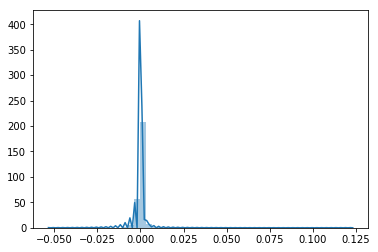

In [171]:
seaborn.distplot(ridge_reg_best.coef_.flatten())

### 2. Test out model on development data, computing its MAP@20, and investigating the quality of the rankings

In [74]:
def test_model_on_train(model):
    y_train_pred = model.predict(x_train)
    train_distances = pairwise_distances(y_train, y_train_pred)
    train_scores = []
    train_pos_list = []

    for i in range(num_train):
        pred_dist_idx = list(np.argsort(train_distances[i]))
        train_pos = pred_dist_idx.index(i)
        train_pos_list.append(train_pos)
        if train_pos < 20:
            train_scores.append(1 / (train_pos + 1))
        else:
            train_scores.append(0.0)

    print("Train MAP@20:", np.mean(train_scores))
    print("Mean position of true image", np.mean(train_pos_list))
    print("Median position of true image", np.median(train_pos_list))
    return train_pos_list
    
def test_model_on_dev(model):
    y_dev_pred = model.predict(x_dev)
    dev_distances = pairwise_distances(y_dev, y_dev_pred)
    dev_scores = []
    dev_pos_list = []

    for i in range(num_dev):
        pred_dist_idx = list(np.argsort(dev_distances[i]))
        dev_pos = pred_dist_idx.index(i)
        dev_pos_list.append(dev_pos)
        if dev_pos < 20:
            dev_scores.append(1 / (dev_pos + 1))
        else:
            dev_scores.append(0.0)

    print("Development MAP@20:", np.mean(dev_scores))
    print("Mean position of true image", np.mean(dev_pos_list))
    print("Median position of true image", np.median(dev_pos_list))
    return dev_pos_list

### modify here

In [82]:
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.7262113357612245
Mean position of true image 8.84575
Median position of true image 0.0

Development MAP@20: 0.30040554392073354
Mean position of true image 34.338
Median position of true image 6.0


In [86]:
# 整理过的4805维bow, pool，ridge90，tag2.5, 用v4就好
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.7500135947412796
Mean position of true image 6.36075
Median position of true image 0.0

Development MAP@20: 0.3326615526651711
Mean position of true image 19.388
Median position of true image 5.0


In [21]:
# Tag weight 2, only fc
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.5965282110766341
Mean position of true image 11.418
Median position of true image 1.0

Development MAP@20: 0.3261975852643228
Mean position of true image 26.5445
Median position of true image 5.0


In [42]:
# Tag weight 1, only pool
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.8420450678234733
Mean position of true image 2.534625
Median position of true image 0.0

Development MAP@20: 0.2140915103944903
Mean position of true image 88.9455
Median position of true image 12.0


In [30]:
# Tag weight 2, , only pool
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.8719573981944484
Mean position of true image 1.477375
Median position of true image 0.0

Development MAP@20: 0.27809352862479797
Mean position of true image 47.9145
Median position of true image 7.0


In [34]:
# Tag weight 5, , only pool
train_pos_list = test_model_on_train(ridge_reg)
print()
dev_pos_list = test_model_on_dev(ridge_reg)

Train MAP@20: 0.685532953811432
Mean position of true image 6.0485
Median position of true image 0.0

Development MAP@20: 0.24826639030688952
Mean position of true image 41.665
Median position of true image 9.0


In [ ]:
def inspect_model_performance(image_index, model):
    

### 3. Inspect

### 4. Finally use a model to compute top-20 predictions on the test data that can be submitted to Kaggle

In [44]:
# create test predictions
def output_submission(model):
    x_train_all = np.concatenate([x_train, x_dev])
    y_train_all = np.concatenate([y_train, y_dev])
    model.fit(x_train_all, y_train_all)
    y_test_pred = model.predict(x_test)
    test_distances = pairwise_distances(y_test, y_test_pred)
    pred_rows = []

    for i in range(num_test):
        test_dist_idx = list(np.argsort(test_distances[i]))
        top_20 = test_dist_idx[:20]
        row = ["%d.jpg" % i for i in test_dist_idx[:20]]
        pred_rows.append(" ".join(row))

    with open("ojbkkk_submission.csv", "w") as f:
        f.write("Descritpion_ID,Top_20_Image_IDs\n")
        for i, row in enumerate(pred_rows):
            f.write("%d.txt,%s\n" % (i, row))

    print("Output written!")

In [45]:
output_submission(ridge_reg)

Output written!
